#Objetivo: Prever o consumo de combustível em frota de caminhões (ex: simular rotas que minimizem gastos energéticos)

In [1]:
import pandas as pd

# Leitura dos dados

In [2]:
url = 'https://github.com/allanspadini/codigos-alura-para-empresas/raw/refs/heads/main/combustivel.csv'

In [3]:
df = pd.read_csv(url)

In [4]:
df.head()

,Date,A1,A2,A3,R1,R2,R3,M1,M2,M3,P1,P2,P3,D1
0,01/02/1995,1.127,1.104,1.231,1.079,1.063,1.167,1.170,1.159,1.298,1.272,1.250,1.386,1.104
1,01/09/1995,1.134,1.111,1.232,1.086,1.070,1.169,1.177,1.164,1.300,1.279,1.256,1.387,1.102
2,01/16/1995,1.126,1.102,1.231,1.078,1.062,1.169,1.168,1.155,1.299,1.271,1.249,1.385,1.100
3,01/23/1995,1.132,1.110,1.226,1.083,1.068,1.165,1.177,1.165,1.296,1.277,1.256,1.378,1.095
4,01/30/1995,1.131,1.109,1.221,1.083,1.068,1.162,1.176,1.163,1.291,1.275,1.255,1.370,1.090


# Etapa 1: Visualização da série temporal

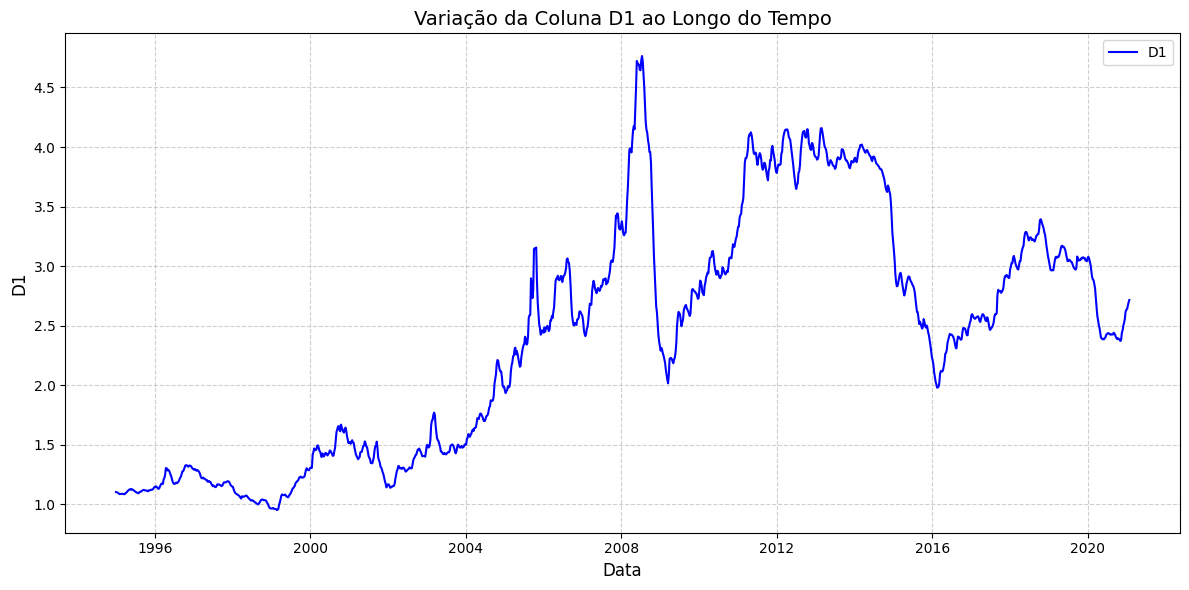

In [6]:
import matplotlib.pyplot as plt

# Converter a coluna 'Date' para o formato datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Plotar os dados da coluna 'D1' ao longo da 'Date'
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['D1'], label='D1', color='blue')

# Configurar o gráfico
plt.title('Variação da Coluna D1 ao Longo do Tempo', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('D1', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Exibir o gráfico
plt.show()


# Etapa 2: Organizar os dados para a Prophet

https://facebook.github.io/prophet/docs/quick_start.html

In [7]:
# Renomear as colunas para o formato esperado pelo Prophet
df_prophet = df[['Date', 'D1']].rename(columns={'Date': 'ds', 'D1': 'y'})

In [8]:
df_prophet.head()

,ds,y
0,1995-01-02,1.104
1,1995-01-09,1.102
2,1995-01-16,1.100
3,1995-01-23,1.095
4,1995-01-30,1.090


# Etapa 3: Dividir em treino e teste (considere que queremos aprender com o passado para prever o futuro)

In [86]:
# Definir a proporção entre treino e teste
train_size = 0.95  # 80% dos dados para treino, 20% para teste

# Calcular o índice onde ocorre a divisão
split_index = int(len(df_prophet) * train_size)

# Dividir o DataFrame em treino e teste
train = df_prophet.iloc[:split_index]  # Treino: primeiras 80%
test = df_prophet.iloc[split_index:]   # Teste: últimas 20%

In [87]:
train

,ds,y
0,1995-01-02,1.104
1,1995-01-09,1.102
2,1995-01-16,1.100
3,1995-01-23,1.095
4,1995-01-30,1.090
...,...,...
1287,2019-09-02,2.976
1288,2019-09-09,2.971
1289,2019-09-16,2.987
1290,2019-09-23,3.081


# Etapa 3: Criar um modelo básico com a Prophet

In [88]:
from prophet import Prophet

In [107]:
modelo = Prophet(yearly_seasonality=True,changepoint_prior_scale=0.5)
modelo.add_seasonality(name='monthly', period=30.5, fourier_order=5)  # Sazonalidade mensal
modelo.add_seasonality(name='weekly', period=7, fourier_order=3)      # Sazonalidade semanal

In [108]:
modelo.fit(train)

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx4r57sdj/y3mc_03v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx4r57sdj/85bvcc_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38027', 'data', 'file=/tmp/tmpx4r57sdj/y3mc_03v.json', 'init=/tmp/tmpx4r57sdj/85bvcc_0.json', 'output', 'file=/tmp/tmpx4r57sdj/prophet_modeli86g2y_w/prophet_model-20250213002840.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:28:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:28:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# Etapa 4: Fazer previsões com a Prophet

In [109]:
# Fazer previsões no conjunto de teste
future = test[['ds']]  # O Prophet exige apenas a coluna 'ds' para prever
forecast = modelo.predict(future)

In [110]:
# Avaliar o desempenho do modelo
# Calcular as métricas de erro (MAE e RMSE)
y_true = test['y'].values  # Valores reais
y_pred = forecast['yhat'].values  # Previsões do modelo


# Etapa 5: Verificar os resultados

In [111]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [112]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

In [113]:
# Exibir as métricas
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 0.37
Root Mean Squared Error (RMSE): 0.42


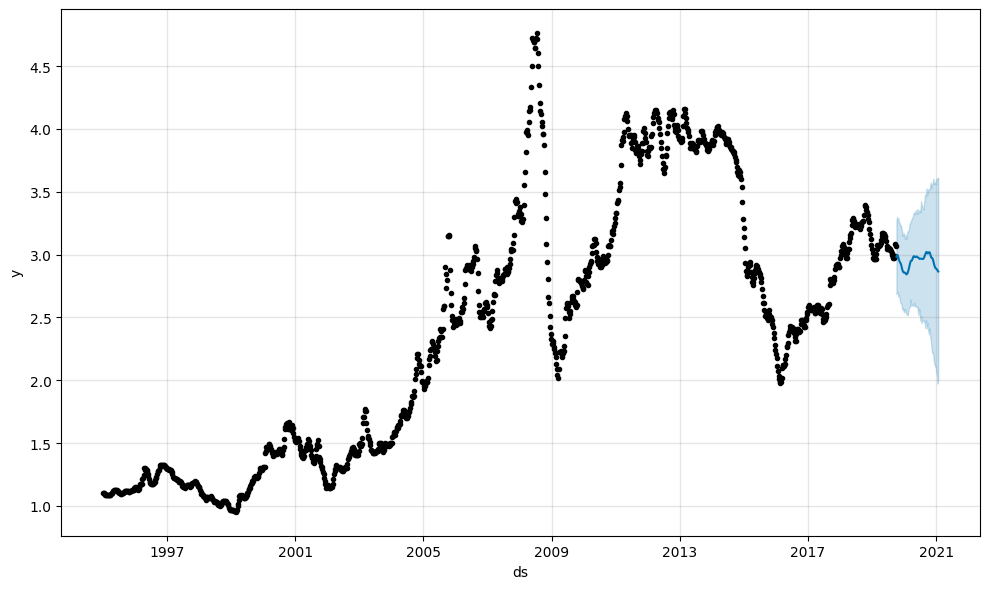

In [114]:
modelo.plot(forecast);

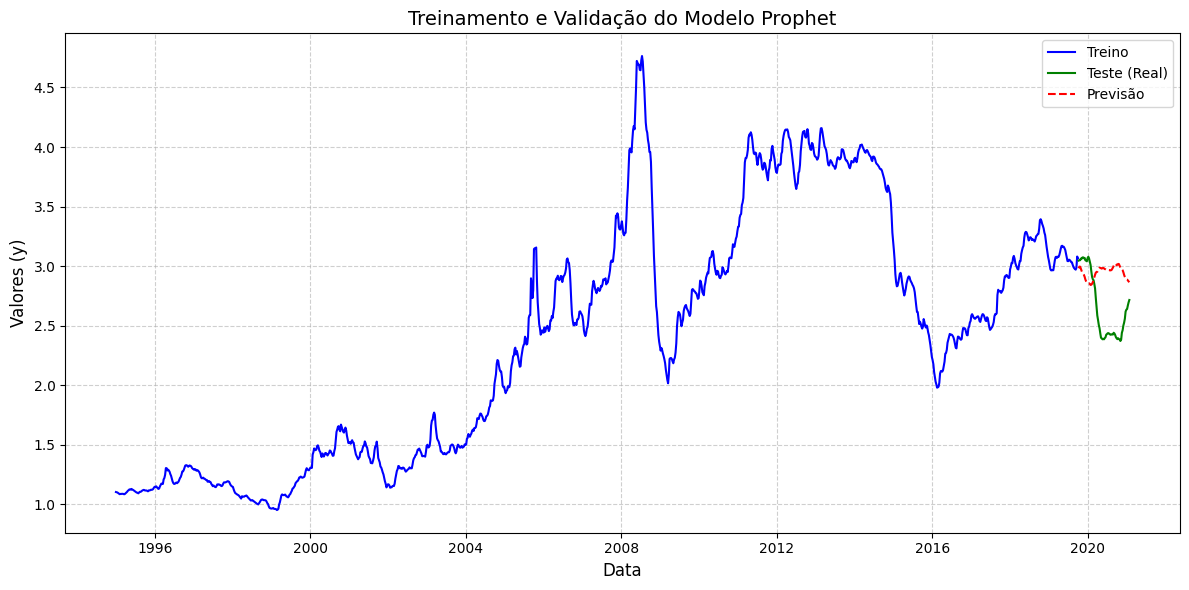

In [115]:
# Plotar os resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label='Treino', color='blue')
plt.plot(test['ds'], test['y'], label='Teste (Real)', color='green')
plt.plot(test['ds'], forecast['yhat'], label='Previsão', color='red', linestyle='--')

plt.title('Treinamento e Validação do Modelo Prophet', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Valores (y)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()